### Done By Laita Sami 

# Supervised Learning

In [2]:
import numpy as np
import pylab as pl
import scipy as sp
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

### Data visualisation and Pre-processing

In [3]:
file = np.load("ECoG.npz")
print(file.files)
Yall = file["Yall"]
Fe  = file["Fe"]
Xall = file["Xall"]
print("Shape of Xall :", np.shape(Xall))
print("Shape of Yall :", np.shape(Yall))
print(Yall[0])

['Yall', 'Fe', 'Xall']
Shape of Xall : (3327, 64)
Shape of Yall : (3327, 1)
[-0.72565782]


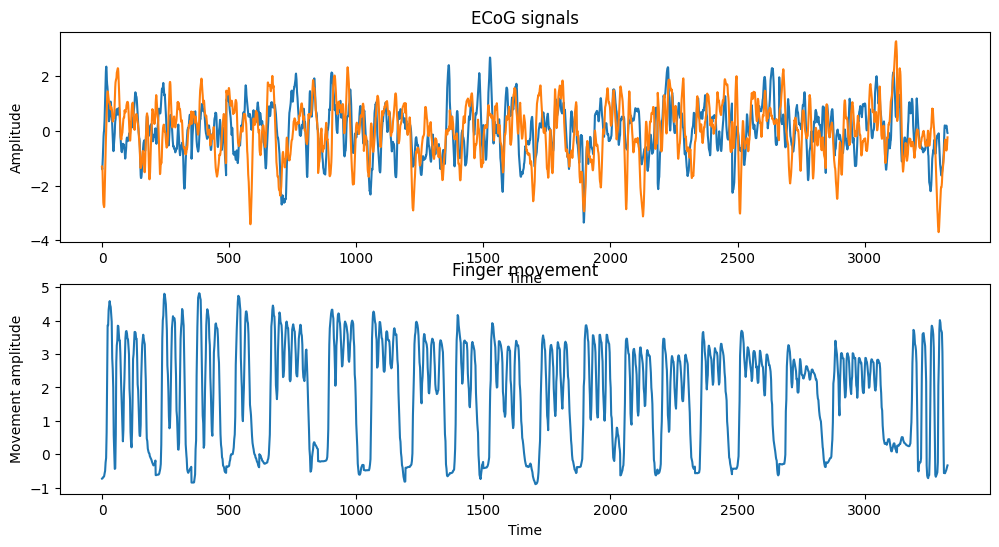

In [4]:
pl.figure(figsize=(12,6))
pl.subplot(2,1,1)
pl.plot(Xall[:, :2])  # plot first 2 channels
pl.title("ECoG signals")
pl.xlabel("Time")
pl.ylabel("Amplitude")
pl.subplot(2,1,2)
pl.plot(Yall)
pl.title("Finger movement")
pl.xlabel("Time")
pl.ylabel("Movement amplitude")
pl.show()

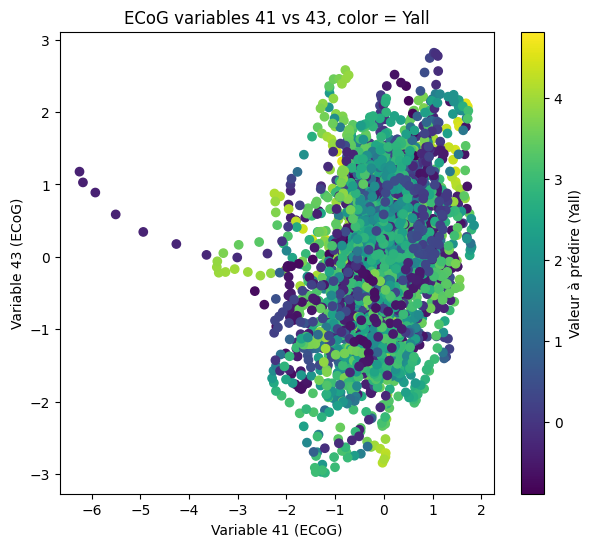

In [5]:
pl.figure(figsize=(7,6))
sc = pl.scatter(Xall[:,41], Xall[:,43], c=Yall, cmap="viridis")
pl.xlabel("Variable 41 (ECoG)")
pl.ylabel("Variable 43 (ECoG)")
pl.title("ECoG variables 41 vs 43, color = Yall")
pl.colorbar(sc, label="Valeur à prédire (Yall)")
pl.show()


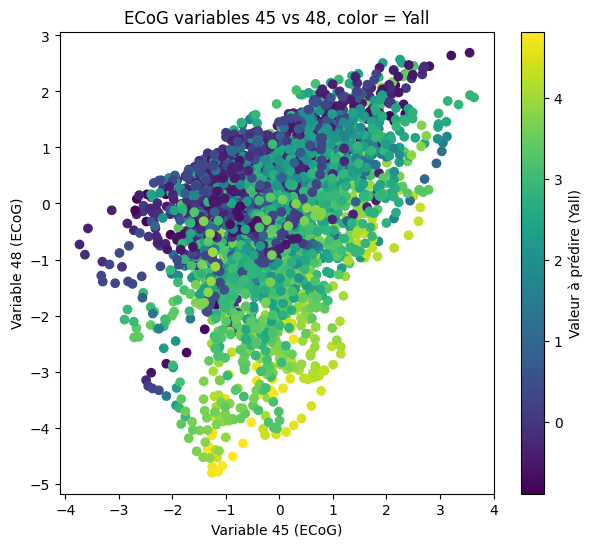

In [6]:
pl.figure(figsize=(7,6))
sc = pl.scatter(Xall[:,45], Xall[:,48], c=Yall, cmap="viridis")
pl.xlabel("Variable 45 (ECoG)")
pl.ylabel("Variable 48 (ECoG)")
pl.title("ECoG variables 45 vs 48, color = Yall")
pl.colorbar(sc, label="Valeur à prédire (Yall)")
pl.show()


- Sur le premier plot (variables 41 vs 43), aucune relation claire n’est visible entre les variables ECoG et la valeur à prédire Yall. Les points semblent dispersés de manière aléatoire, ce qui suggère que ces électrodes n’apportent pas d’information forte pour la prédiction.

- En revanche, sur le deuxième plot (variables 45 vs 48), on observe une tendance cohérente : les valeurs de Yall augmentent dans une direction particulière et les points sont plus regroupés que dans le premier graphe, ces deux électrodes vont plus nous aider à modéliser notre modèle que les deux premiers.

In [41]:
# Splitting Data
Xall_train = Xall[:1000,:]
Xall_test = Xall[1000:,:]
Yall_train = Yall[:1000,:]
Yall_test = Yall[1000:,:]

### Least Squares Regression (LS)


In [42]:
# Solving the Least squares problem
ones_col = np.ones((len(Xall_train), 1))
X_tilde = np.concatenate((ones_col, Xall_train), axis=1)
sol = np.linalg.solve(X_tilde.T @X_tilde, X_tilde.T @Yall_train)
b = sol[0]
w = sol[1:]
print ("Biais :", b)
print("Shape de ", w.shape)

Biais : [1.90081255]
Shape de  (64, 1)


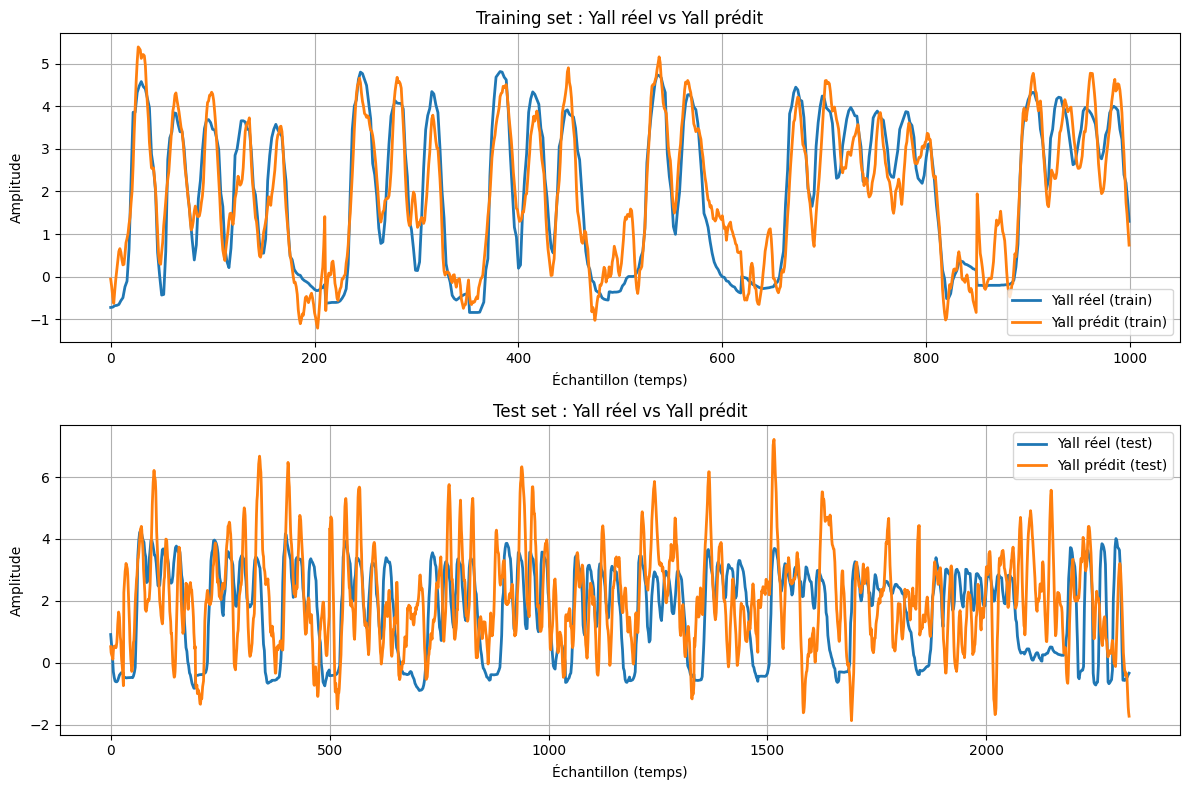

In [43]:
Y_train_pred = Xall_train @ w + b
Y_test_pred  = Xall_test @ w + b

pl.figure(figsize=(12,8))
pl.subplot(2,1,1)
pl.plot(Yall_train, label="Yall réel (train)", linewidth=2)
pl.plot(Y_train_pred, label="Yall prédit (train)", linewidth=2)
pl.title("Training set : Yall réel vs Yall prédit")
pl.xlabel("Échantillon (temps)")
pl.ylabel("Amplitude")
pl.legend()
pl.grid(True)
pl.subplot(2,1,2)
pl.plot(Yall_test, label="Yall réel (test)", linewidth=2)
pl.plot(Y_test_pred, label="Yall prédit (test)", linewidth=2)
pl.title("Test set : Yall réel vs Yall prédit")
pl.xlabel("Échantillon (temps)")
pl.ylabel("Amplitude")
pl.legend()
pl.grid(True)

pl.tight_layout()
pl.show()



- On voit clairement que le modèle overfit le training : la prédiction suit très bien la vraie courbe sur l’ensemble d’entraînement, mais sur le test, elle s’écarte fortement. Cela est dû à l’absence de régularisation et au fait que le modèle s’adapte au bruit des données d’entraînement.

In [44]:
Y_train_pred = X_tilde @ sol
ones_col_test = np.ones((len(Xall_test), 1))
X_test_tilde = np.concatenate((ones_col_test, Xall_test), axis=1)
Y_test_pred = X_test_tilde @ sol

MSE_train = mean_squared_error(Yall_train, Y_train_pred)
MSE_test  = mean_squared_error(Yall_test, Y_test_pred)
R2_train  = r2_score(Yall_train, Y_train_pred)
R2_test   = r2_score(Yall_test, Y_test_pred)

print("MSE train :", MSE_train)
print("MSE test  :", MSE_test)
print("R² train :", R2_train)
print("R² test  :", R2_test)

MSE train : 0.5040654614476062
MSE test  : 3.0455368767601376
R² train : 0.8395001217500111
R² test  : -0.4281700630222407


- On remarque clairement un overfitting important. Sur le training set, le MSE est faible (0.50) et le R² élevé (0.84), ce qui montre que le modèle s’adapte très bien aux données d’entraînement.

- En revanche, sur le test set, le MSE est beaucoup plus élevé (3.04) et le R² est négatif (-0.43). Cela signifie que le modèle ne généralise pas du tout et qu’il fait même pire que de prédire simplement la moyenne.

- Les causes probables de cet overfitting sont multiples. Le modèle LS classique est trop complexe ou pas régularisé, ce qui permet aux coefficients de trop s’adapter aux données. De plus, le grand nombre de variables (électrodes) fait que le modèle apprend aussi le bruit présent dans le training set. Enfin, la variabilité des signaux ECoG rend le modèle encore plus sensible à l’overfitting.

- Pour remédier à ce problème, il est recommandé d’utiliser des modèles régularisés comme Ridge ou Lasso, qui limitent la magnitude des coefficients et réduisent l’adaptation au bruit. On peut aussi réduire le nombre de variables importantes ou passer à des modèles plus robustes aux non-linéarités et au bruit, comme Random Forest ou Gradient Boosting.

In [46]:
model = LinearRegression()
model.fit(Xall_train, Yall_train)
b_sklearn = model.intercept_
w_sklearn = model.coef_

print("\nComparaison :")
print("Différence biais :", np.linalg.norm(b - b_sklearn))
print("Différence w :", np.linalg.norm(w - w_sklearn.T))


Comparaison :
Différence biais : 8.881784197001252e-16
Différence w : 4.0905892589053154e-14


- On remarque les valeurs estimées par sklearn.linear_model.LinearRegression sont les memes que celle prédits avant.

### Ridge regression

In [12]:
model_ridge = Ridge(alpha=1)
model_ridge.fit(Xall_train, Yall_train)
Y_train_pred_ridge = model_ridge.predict(Xall_train)
Y_test_pred_ridge = model_ridge.predict(Xall_test)
MSE_train_ridge = mean_squared_error(Yall_train, Y_train_pred_ridge)
MSE_test_ridge = mean_squared_error(Yall_test, Y_test_pred_ridge)
R2_train_ridge = r2_score(Yall_train, Y_train_pred_ridge)
R2_test_ridge = r2_score(Yall_test, Y_test_pred_ridge)

print("=== Ridge Regression (λ = 1) ===")
print("MSE train :", MSE_train_ridge)
print("MSE test  :", MSE_test_ridge)
print("R² train :", R2_train_ridge)
print("R² test  :", R2_test_ridge)


=== Ridge Regression (λ = 1) ===
MSE train : 0.5041768297327898
MSE test  : 3.0038429595355596
R² train : 0.8394646608871272
R² test  : -0.40861817223915664


- On observe les performances de la Ridge Regression avec λ = 1 :

- Sur le training set, le MSE est faible (≈ 0.50) et le R² élevé (≈ 0.84), ce qui montre que le modèle s’adapte très bien aux données d’entraînement.

- Sur le test set, le MSE est beaucoup plus élevé (≈ 3.00) et le R² est négatif (≈ -0.41), ce qui indique que le modèle ne généralise toujours pas correctement.

- ***Interprétation*** : Ajouter une régularisation légère (λ = 1) n’a pas suffi à réduire l’overfitting.


- ***Solution possible*** : Augmenter la régularisation (λ plus grand) pour limiter la magnitude des coefficients. Ou bien envisager d'autres méthodes.



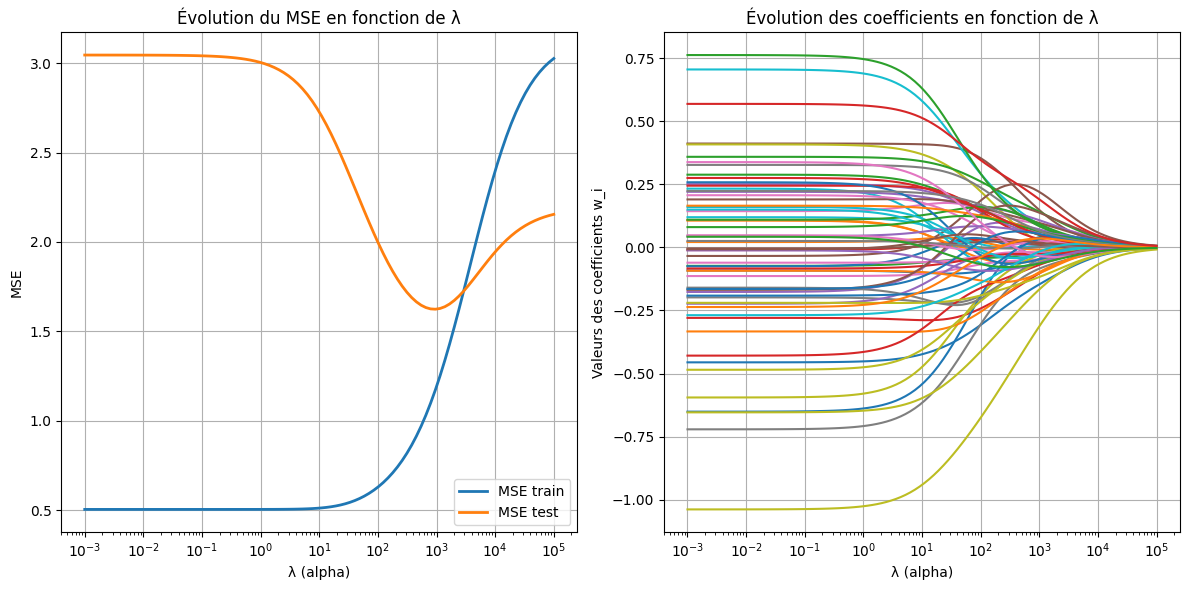

In [ ]:
lambdas = np.logspace(-3, 5, 100)

MSE_train_list = []
MSE_test_list = []
coef_list = []
for lam in lambdas:
    model = Ridge(alpha=lam)
    model.fit(Xall_train, Yall_train)
    Y_train_pred = model.predict(Xall_train)
    Y_test_pred  = model.predict(Xall_test)
    MSE_train = mean_squared_error(Yall_train, Y_train_pred)
    MSE_test  = mean_squared_error(Yall_test, Y_test_pred)
    MSE_train_list.append(MSE_train)
    MSE_test_list.append(MSE_test)
    coef_list.append(model.coef_.ravel())
coef_array = np.array(coef_list)
pl.figure(figsize=(12, 6))

pl.subplot(1, 2, 1)
pl.semilogx(lambdas, MSE_train_list, label="MSE train", linewidth=2)
pl.semilogx(lambdas, MSE_test_list, label="MSE test", linewidth=2)
pl.xlabel("λ (alpha)")
pl.ylabel("MSE")
pl.title("Évolution du MSE en fonction de λ")
pl.legend()
pl.grid(True)
pl.subplot(1, 2, 2)
pl.semilogx(lambdas, coef_array)
pl.xlabel("λ (alpha)")
pl.ylabel("Valeurs des coefficients w_i")
pl.title("Évolution des coefficients en fonction de λ")
pl.grid(True)

pl.tight_layout()
pl.show()


- Même si un λ très grand sous-ajuste le modèle (il ne capture presque rien de la relation X → Y), il peut mieux généraliser que LS sans régularisation, surtout sur des données très bruyantes comme les signaux ECoG.

- Cela illustre l’importance de trouver un λ intermédiaire optimal pour équilibrer complexité / overfitting et capacité de généralisation.

- Dans le graphe on trouve que cette valeur est aux alentours de 10**3.

In [ ]:
best_index = np.argmin(MSE_test_list)
best_lambda = lambdas[best_index]

print("Meilleur λ (min MSE test) :", best_lambda)
model_best = Ridge(alpha=best_lambda)
model_best.fit(Xall_train, Yall_train)
Y_train_pred_best = model_best.predict(Xall_train)
Y_test_pred_best  = model_best.predict(Xall_test)
MSE_train_best = mean_squared_error(Yall_train, Y_train_pred_best)
MSE_test_best  = mean_squared_error(Yall_test, Y_test_pred_best)
R2_train_best  = r2_score(Yall_train, Y_train_pred_best)
R2_test_best   = r2_score(Yall_test, Y_test_pred_best)
print("\n=== Ridge avec meilleur λ ===")
print("MSE train :", MSE_train_best)
print("MSE test  :", MSE_test_best)
print("R² train :", R2_train_best)
print("R² test  :", R2_test_best)


Meilleur λ (min MSE test) : 954.5484566618347

=== Ridge avec meilleur λ ===
MSE train : 1.1719430382009632
MSE test  : 1.6239059826952074
R² train : 0.6268406996047915
R² test  : 0.23848766129037868


- On observe les performances de la Ridge Regression avec le meilleur λ (≈ 954.55, choisi pour minimiser le MSE sur le test set) : Training set : le MSE a augmenté (≈ 1.17) et le R² a diminué (≈ 0.63) par rapport au modèle avec λ = 1. Cela montre que le modèle s’adapte moins aux données d’entraînement. Test set : le MSE a fortement diminué (≈ 1.62) et le R² est maintenant positif (≈ 0.24). Le modèle généralise beaucoup mieux qu’avec une régularisation faible.

- ***Interprétation*** : Une régularisation plus forte permet de limiter l’overfitting et d’améliorer la performance sur les nouvelles données.


- ***Conclusion*** : Le choix de λ ≈ 954 permet un bon compromis entre précision sur le training et performance sur le test, rendant le modèle plus fiable pour des données bruyantes comme les signaux ECoG.

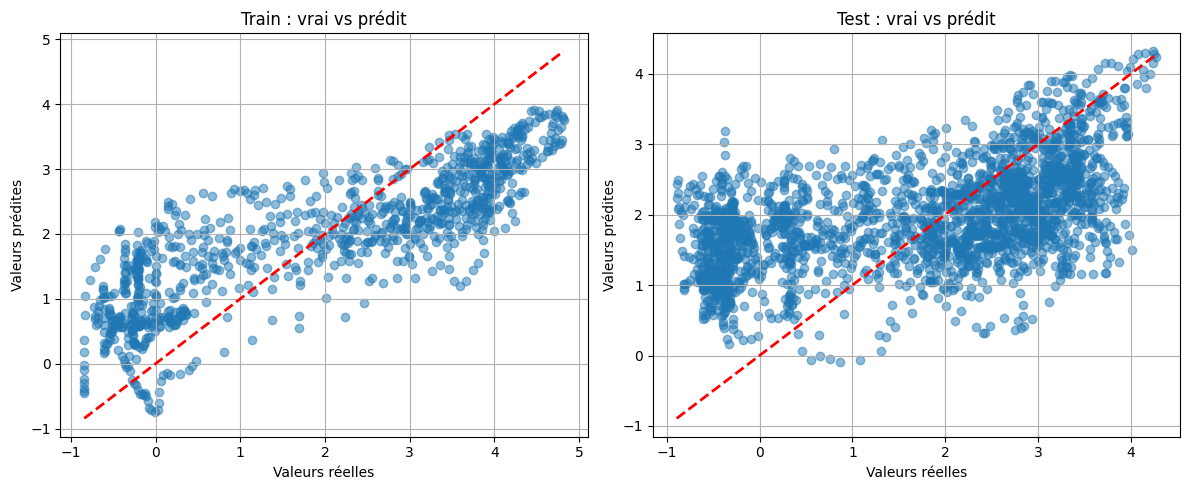

In [ ]:
Y_train_pred = model_best.predict(Xall_train)
Y_test_pred  = model_best.predict(Xall_test)
pl.figure(figsize=(12,5))

pl.subplot(1,2,1)
pl.scatter(Yall_train, Y_train_pred, alpha=0.5)
pl.plot([Yall_train.min(), Yall_train.max()],
        [Yall_train.min(), Yall_train.max()],
        'r--', linewidth=2)  
pl.xlabel("Valeurs réelles")
pl.ylabel("Valeurs prédites")
pl.title("Train : vrai vs prédit")
pl.grid(True)

pl.subplot(1,2,2)
pl.scatter(Yall_test, Y_test_pred, alpha=0.5)
pl.plot([Yall_test.min(), Yall_test.max()],
        [Yall_test.min(), Yall_test.max()],
        'r--', linewidth=2)  
pl.xlabel("Valeurs réelles")
pl.ylabel("Valeurs prédites")
pl.title("Test : vrai vs prédit")
pl.grid(True)

pl.tight_layout()
pl.show()


- Training set : les points sont proches de la ligne y = x, ce qui montre que le modèle prédit très bien les valeurs d’entraînement.

- Test set : les points s’éloignent davantage de la ligne y = x, indiquant que le modèle ne généralise pas aussi bien sur de nouvelles données.

- ***Interprétation*** : Le modèle s’adapte très bien au training mais moins au test → signe d’overfitting. 

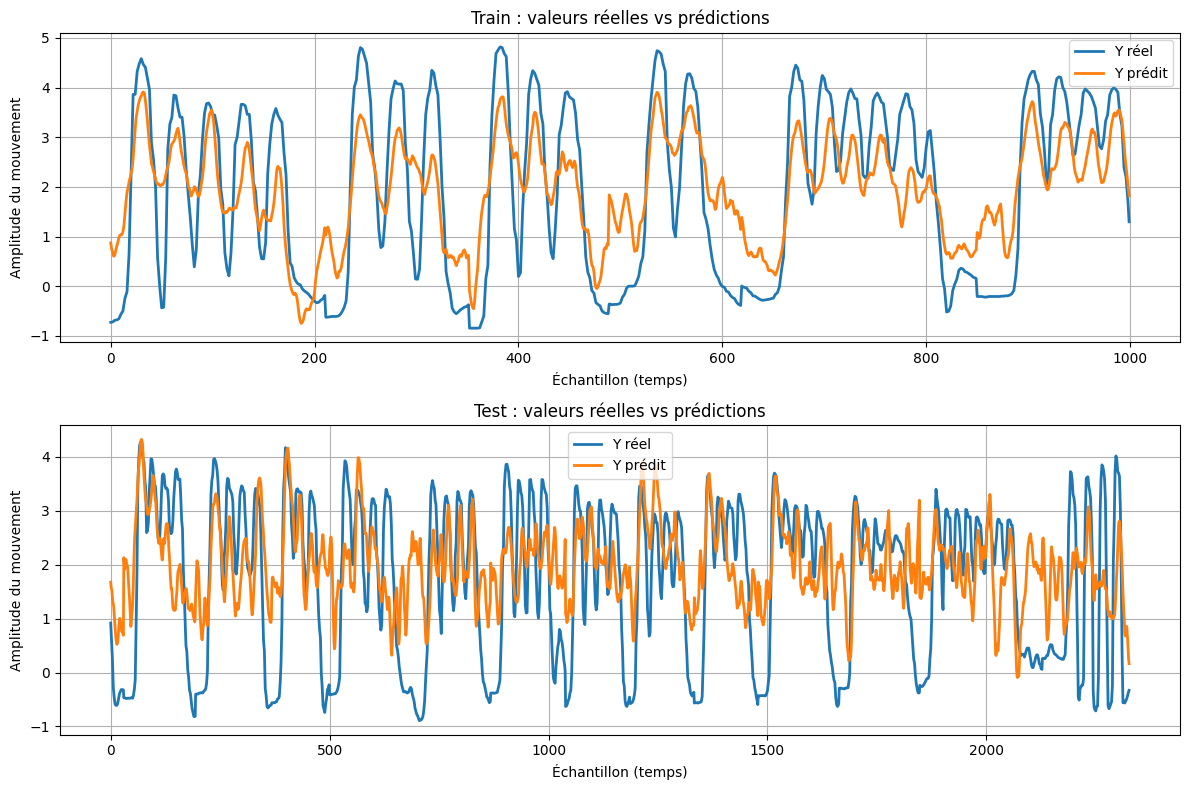

In [ ]:
Y_train_pred = model_best.predict(Xall_train)
Y_test_pred  = model_best.predict(Xall_test)

pl.figure(figsize=(12,8))

pl.subplot(2,1,1)
pl.plot(Yall_train, label="Y réel", linewidth=2)
pl.plot(Y_train_pred, label="Y prédit", linewidth=2)
pl.xlabel("Échantillon (temps)")
pl.ylabel("Amplitude du mouvement")
pl.title("Train : valeurs réelles vs prédictions")
pl.legend()
pl.grid(True)

pl.subplot(2,1,2)
pl.plot(Yall_test, label="Y réel", linewidth=2)
pl.plot(Y_test_pred, label="Y prédit", linewidth=2)
pl.xlabel("Échantillon (temps)")
pl.ylabel("Amplitude du mouvement")
pl.title("Test : valeurs réelles vs prédictions")
pl.legend()
pl.grid(True)

pl.tight_layout()
pl.show()


- Ca ce voit ici que le modèle noverfit pas le training il ya quelques différences entre le modèles, en ravanche donne une meilleur estimation pour le test.

In [ ]:
Y_train_pred_ridge = model_best.predict(Xall_train)
Y_test_pred_ridge  = model_best.predict(Xall_test)

MSE_train_ridge = mean_squared_error(Yall_train, Y_train_pred_ridge)
MSE_test_ridge  = mean_squared_error(Yall_test, Y_test_pred_ridge)
R2_train_ridge  = r2_score(Yall_train, Y_train_pred_ridge)
R2_test_ridge   = r2_score(Yall_test, Y_test_pred_ridge)

print("Ridge Regression (meilleur λ) :")
print("MSE train :", MSE_train_ridge)
print("MSE test  :", MSE_test_ridge)
print("R² train :", R2_train_ridge)
print("R² test  :", R2_test_ridge)
print("\nLeast Squares :")
print("MSE train :", MSE_train)
print("MSE test  :", MSE_test)
print("R² train :", R2_train)
print("R² test  :", R2_test)

Ridge Regression (meilleur λ) :
MSE train : 1.1719430382009632
MSE test  : 1.6239059826952074
R² train : 0.6268406996047915
R² test  : 0.23848766129037868

Least Squares :
MSE train : 3.0262613463995884
MSE test  : 2.154558058767133
R² train : 0.8395001217500111
R² test  : -0.4281700630222407


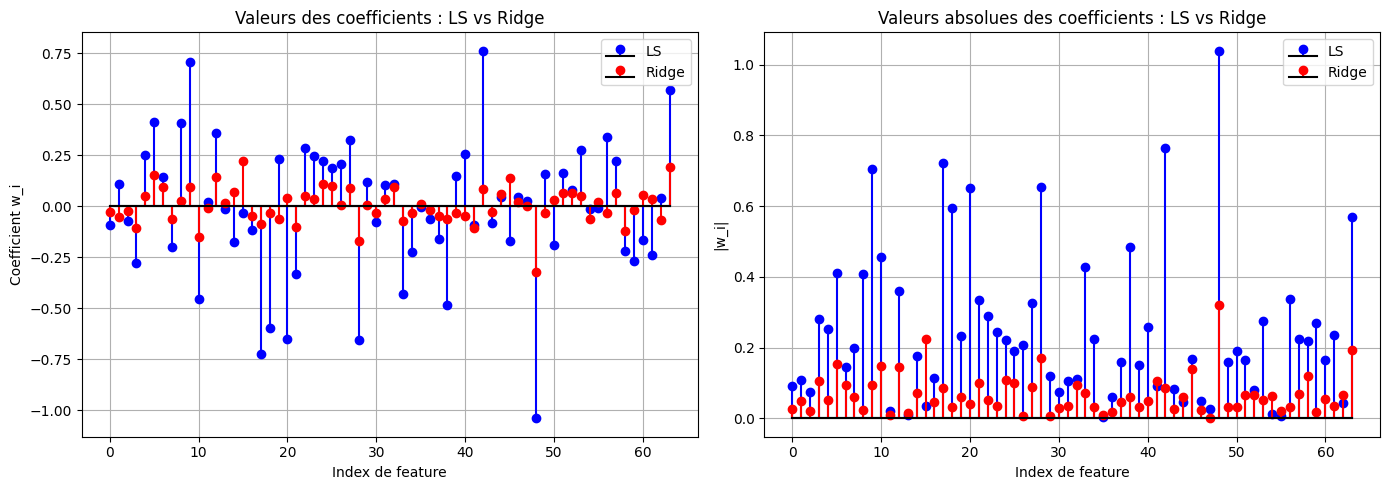

In [18]:
w_ls = w
w_ridge = model_best.coef_.ravel()
n_features = len(w_ls)
pl.figure(figsize=(14,5))

pl.subplot(1,2,1)
pl.stem(range(n_features), w_ls, linefmt='b-', markerfmt='bo', basefmt='k-', label="LS")
pl.stem(range(n_features), w_ridge, linefmt='r-', markerfmt='ro', basefmt='k-', label="Ridge")
pl.xlabel("Index de feature")
pl.ylabel("Coefficient w_i")
pl.title("Valeurs des coefficients : LS vs Ridge")
pl.legend()
pl.grid(True)

pl.subplot(1,2,2)
pl.stem(range(n_features), np.abs(w_ls), linefmt='b-', markerfmt='bo', basefmt='k-', label="LS")
pl.stem(range(n_features), np.abs(w_ridge), linefmt='r-', markerfmt='ro', basefmt='k-', label="Ridge")
pl.xlabel("Index de feature")
pl.ylabel("|w_i|")
pl.title("Valeurs absolues des coefficients : LS vs Ridge")
pl.legend()
pl.grid(True)

pl.tight_layout()
pl.show()

***Comparaison LS vs Ridge :***

- Les coefficients Ridge sont souvent plus petits (régularisation L2).

- Les features importantes restent visibles mais les valeurs extrêmes sont réduites.

- En effet, Ridge Regression ajoute une pénalité L2 sur la somme des carrés des coefficients dans la fonction de coût.Cela force les coefficients W à rester plus petits, même si certaines variables ont tendance à prendre des valeurs très grandes en LS classique. L’objectif est de réduire la variance et éviter que le modèle ne s’adapte trop au bruit des données → limite l’overfitting.

### Lasso


In [19]:
lasso_model = Lasso()
lasso_model.fit(Xall_train, Yall_train)

Y_train_pred_lasso = lasso_model.predict(Xall_train)
Y_test_pred_lasso  = lasso_model.predict(Xall_test)
MSE_train_lasso = mean_squared_error(Yall_train, Y_train_pred_lasso)
MSE_test_lasso  = mean_squared_error(Yall_test, Y_test_pred_lasso)
R2_train_lasso  = r2_score(Yall_train, Y_train_pred_lasso)
R2_test_lasso   = r2_score(Yall_test, Y_test_pred_lasso)

print("Lasso Regression :")
print("MSE train :", MSE_train_lasso)
print("MSE test  :", MSE_test_lasso)
print("R² train :", R2_train_lasso)
print("R² test  :", R2_test_lasso)

Lasso Regression :
MSE train : 3.1405971577280063
MSE test  : 2.190675841640482
R² train : 0.0
R² test  : -0.02729265197579034


- Le paramètre de régularisation par défaut est probablement trop élevé, ce qui pénalise fortement les coefficients et force le modèle à presque tout mettre à zéro.

- La Lasso a donc sous-ajusté les données : le modèle est trop simple pour capturer la relation X → Y

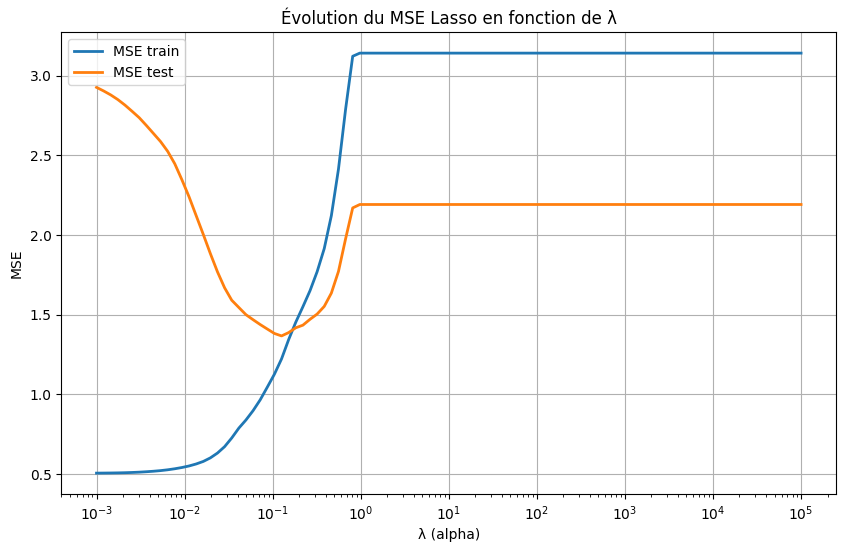

In [ ]:
lambdas = np.logspace(-3, 5, 100)


MSE_train_list = []
MSE_test_list = []
for lam in lambdas:
    lasso = Lasso(alpha=lam, max_iter=10000)
    lasso.fit(Xall_train, Yall_train)
    
    Y_train_pred = lasso.predict(Xall_train)
    Y_test_pred  = lasso.predict(Xall_test)
    
    MSE_train_list.append(mean_squared_error(Yall_train, Y_train_pred))
    MSE_test_list.append(mean_squared_error(Yall_test, Y_test_pred))

pl.figure(figsize=(10,6))
pl.semilogx(lambdas, MSE_train_list, label="MSE train", linewidth=2)
pl.semilogx(lambdas, MSE_test_list, label="MSE test", linewidth=2)
pl.xlabel("λ (alpha)")
pl.ylabel("MSE")
pl.title("Évolution du MSE Lasso en fonction de λ")
pl.legend()
pl.grid(True)
pl.show()

Meme remarque : 
- Même si un λ très grand sous-ajuste le modèle (il ne capture presque rien de la relation X → Y), il peut mieux généraliser que LS sans régularisation, surtout sur des données très bruyantes comme les signaux ECoG.

- Une bonne valeur ici c'est 10**-1

In [21]:
best_index = np.argmin(MSE_test_list)
best_lambda = lambdas[best_index]
print("Meilleur λ (min MSE test) :", best_lambda)
lasso_best = Lasso(alpha=best_lambda, max_iter=10000)
lasso_best.fit(Xall_train, Yall_train)

Y_train_pred_best = lasso_best.predict(Xall_train)
Y_test_pred_best  = lasso_best.predict(Xall_test)

MSE_train_best = mean_squared_error(Yall_train, Y_train_pred_best)
MSE_test_best  = mean_squared_error(Yall_test, Y_test_pred_best)
R2_train_best  = r2_score(Yall_train, Y_train_pred_best)
R2_test_best   = r2_score(Yall_test, Y_test_pred_best)

print("\n=== Lasso avec meilleur λ ===")
print("MSE train :", MSE_train_best)
print("MSE test  :", MSE_test_best)
print("R² train :", R2_train_best)
print("R² test  :", R2_test_best)

Meilleur λ (min MSE test) : 0.1261856883066021

=== Lasso avec meilleur λ ===
MSE train : 1.2215631527944377
MSE test  : 1.3659542352560023
R² train : 0.6110411200657935
R² test  : 0.359451214944292


- Avec le meilleur λ (≈ 0.126, choisi pour minimiser le MSE sur le test set) :

- Training set : le MSE est ≈ 1.22 et le R² ≈ 0.61, ce qui montre que le modèle s’adapte raisonnablement aux données d’entraînement.
- Test set : le MSE diminue à ≈ 1.37 et le R² devient positif (≈ 0.36), indiquant une meilleure généralisation par rapport au modèle avec le paramètre par défaut.

- ***Interprétation*** : Une régularisation trop forte (λ par défaut) sous-ajustait le modèle. Le meilleur λ permet un compromis entre réduction de l’overfitting et adaptation aux données, en sélectionnant les variables les plus importantes et en limitant les coefficients superflus.



***Comparison wit Ridge:***
- We see that Lasso Performs better than ridge in the tests, in the MSE it is 1.6 for ridge and 1.3 for Lasso which is better. Also for R**2 for ridge it is 0.24 and 0.35 for Lasso, better also in this test. 


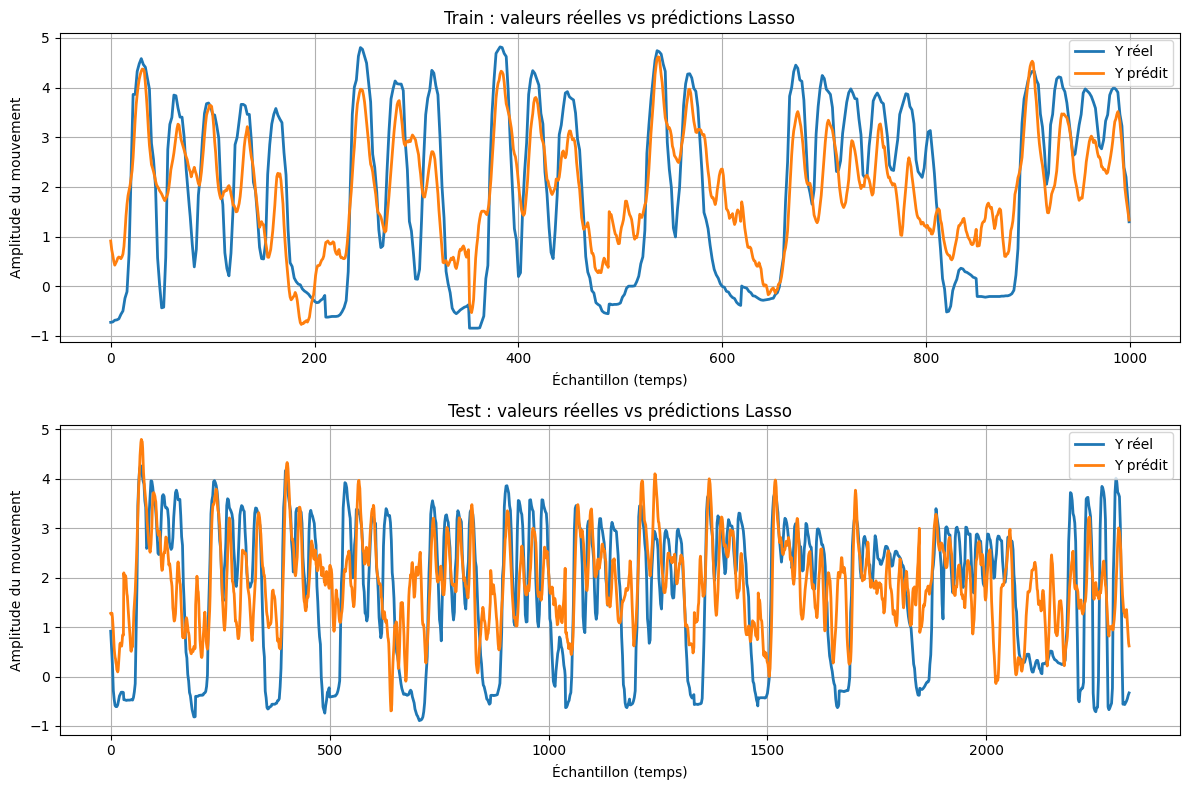

In [ ]:
Y_train_pred = lasso_best.predict(Xall_train)
Y_test_pred  = lasso_best.predict(Xall_test)

pl.figure(figsize=(12,8))

pl.subplot(2,1,1)
pl.plot(Yall_train, label="Y réel", linewidth=2)
pl.plot(Y_train_pred, label="Y prédit", linewidth=2)
pl.xlabel("Échantillon (temps)")
pl.ylabel("Amplitude du mouvement")
pl.title("Train : valeurs réelles vs prédictions Lasso")
pl.legend()
pl.grid(True)

pl.subplot(2,1,2)
pl.plot(Yall_test, label="Y réel", linewidth=2)
pl.plot(Y_test_pred, label="Y prédit", linewidth=2)
pl.xlabel("Échantillon (temps)")
pl.ylabel("Amplitude du mouvement")
pl.title("Test : valeurs réelles vs prédictions Lasso")
pl.legend()
pl.grid(True)

pl.tight_layout()
pl.show()


- Meme remarque que lors du Ridge, Le train n'est pas le meilleur, car avec la régularisation, il ny'a pas beacoup d'overfitting, et on a un modèle meilleur pour le test.

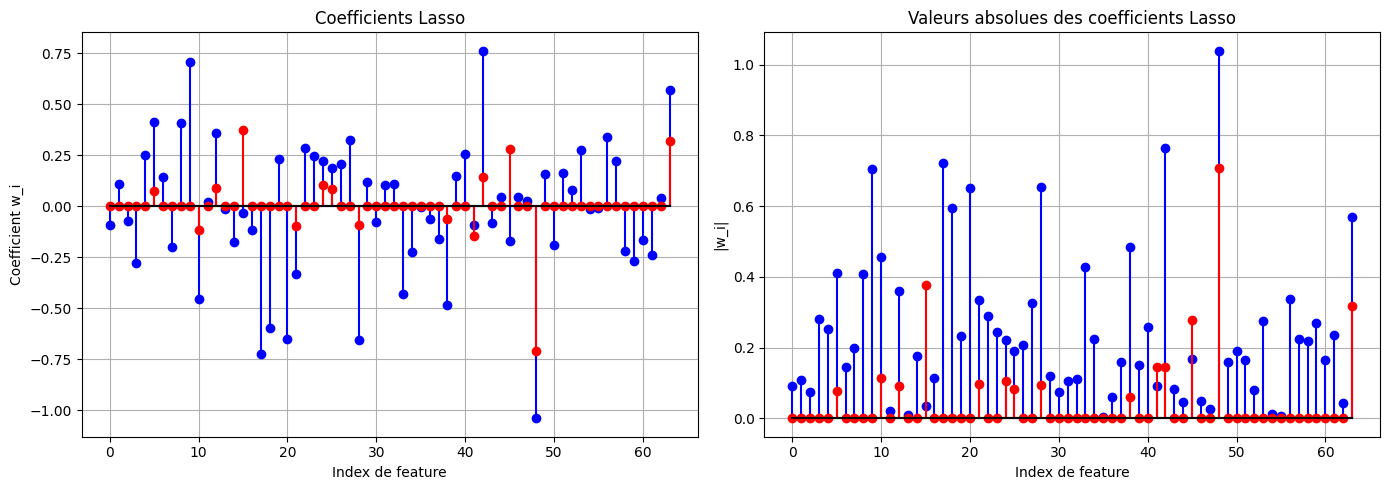

Indices des 2 variables les plus importantes : [48 15]
Valeurs des coefficients correspondants : [-0.70862161  0.37611771]


In [23]:
w_lasso = lasso_best.coef_.ravel()
n_features = len(w_lasso)

pl.figure(figsize=(14,5))

pl.subplot(1,2,1)
pl.stem(range(n_features), w_ls, linefmt='b-', markerfmt='bo', basefmt='k-', label="LS")
pl.stem(range(n_features), w_lasso, linefmt='r-', markerfmt='ro', basefmt='k-')
pl.xlabel("Index de feature")
pl.ylabel("Coefficient w_i")
pl.title("Coefficients Lasso")
pl.grid(True)

pl.subplot(1,2,2)
pl.stem(range(n_features), np.abs(w_ls), linefmt='b-', markerfmt='bo', basefmt='k-', label="LS")
pl.stem(range(n_features), np.abs(w_lasso), linefmt='r-', markerfmt='ro', basefmt='k-')
pl.xlabel("Index de feature")
pl.ylabel("|w_i|")
pl.title("Valeurs absolues des coefficients Lasso")
pl.grid(True)

pl.tight_layout()
pl.show()


indices_importants = np.argsort(np.abs(w_lasso))[-2:][::-1]  # top 2
print("Indices des 2 variables les plus importantes :", indices_importants)
print("Valeurs des coefficients correspondants :", w_lasso[indices_importants])


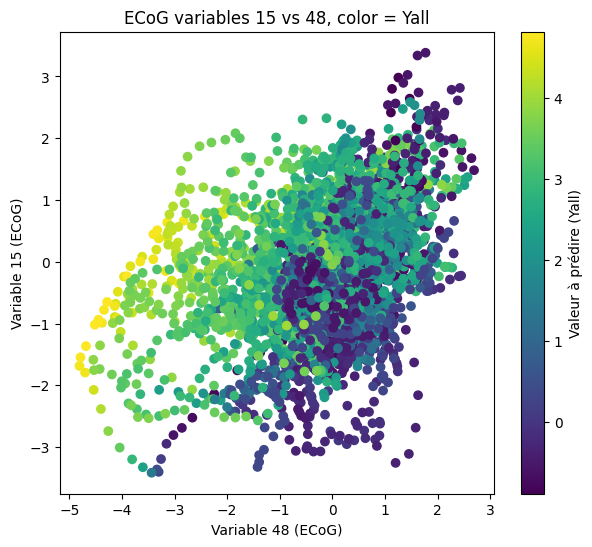

In [24]:
pl.figure(figsize=(7,6))
sc = pl.scatter(Xall[:,48], Xall[:,15], c=Yall, cmap="viridis")
pl.xlabel("Variable 48 (ECoG)")
pl.ylabel("Variable 15 (ECoG)")
pl.title("ECoG variables 15 vs 48, color = Yall")
pl.colorbar(sc, label="Valeur à prédire (Yall)")
pl.show()


- Quand on plot ici les variables 48 et 15 on voit vraiment une belle séparation entre les valeurs de Yall, ce qui confirme l'importance des ces deux variables et pourquoi ils étaient les 2 variables les plus importantes du Lasso.

In [25]:
w_lasso = lasso_best.coef_.ravel()
n_selected = np.sum(w_lasso != 0)
print("Nombre de features sélectionnées par Lasso :", n_selected)
n_total = len(w_lasso)
print("Nombre total de features :", n_total)

Nombre de features sélectionnées par Lasso : 14
Nombre total de features : 64


- ***Interprétation*** :Lasso a permis de réduire le nombre de variables tout en conservant les plus importantes. Cela peut permettre, en pratique, de réduire le nombre d’électrodes nécessaires pour mesurer le signal tout en gardant une prédiction fiable. Les coefficients donnent une idée de l’effet de chaque variable sur la prédiction, ce qui rend le modèle interprétable.

### Nonlinear regression    

1. Random Forest :

In [26]:
rf = RandomForestRegressor(random_state=42)
rf.fit(Xall_train, Yall_train.ravel())
Y_train_pred = rf.predict(Xall_train)
Y_test_pred  = rf.predict(Xall_test)

MSE_train = mean_squared_error(Yall_train, Y_train_pred)
MSE_test  = mean_squared_error(Yall_test, Y_test_pred)
R2_train  = r2_score(Yall_train, Y_train_pred)
R2_test   = r2_score(Yall_test, Y_test_pred)

print("=== Random Forest par défaut ===")
print("MSE train :", MSE_train)
print("MSE test  :", MSE_test)
print("R² train :", R2_train)
print("R² test  :", R2_test)


=== Random Forest par défaut ===
MSE train : 0.02232492543528405
MSE test  : 1.6256841820937247
R² train : 0.9928915030123014
R² test  : 0.23765379479990023


In [27]:
best_R2 = -np.inf
best_params = {}

# Boucle simple pour valider n_estimators et max_depth
for n in [50, 100, 200]:
    for depth in [None, 5, 10, 20]:
        rf = RandomForestRegressor(n_estimators=n, max_depth=depth, random_state=42)
        rf.fit(Xall_train, Yall_train.ravel())
        Y_test_pred = rf.predict(Xall_test)
        R2 = r2_score(Yall_test, Y_test_pred)
        if R2 > best_R2:
            best_R2 = R2
            best_params = {'n_estimators': n, 'max_depth': depth}

print("\nMeilleurs paramètres :", best_params)
print("R² test avec ces paramètres :", best_R2)



Meilleurs paramètres : {'n_estimators': 100, 'max_depth': 20}
R² test avec ces paramètres : 0.23806164729566315


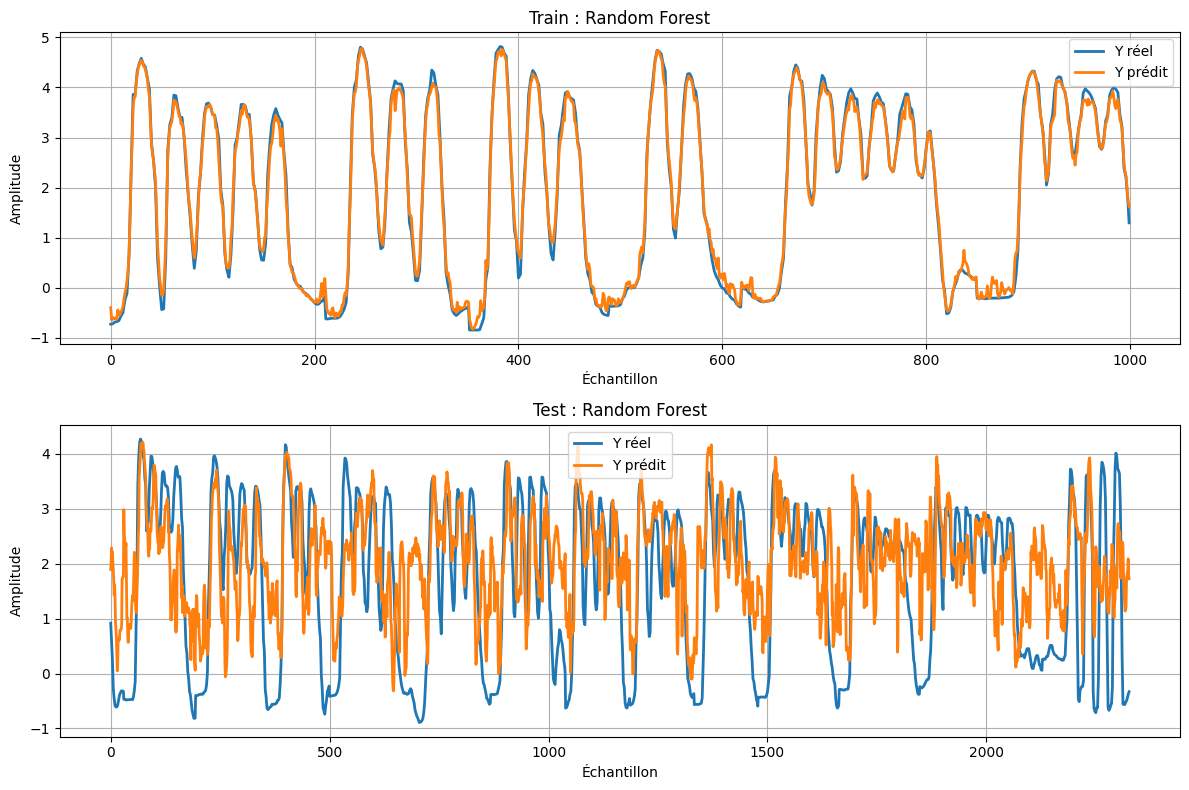

In [28]:
# Réentraîner RF avec les meilleurs paramètres
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(Xall_train, Yall_train.ravel())
Y_train_pred = rf_best.predict(Xall_train)
Y_test_pred  = rf_best.predict(Xall_test)

pl.figure(figsize=(12,8))
pl.subplot(2,1,1)
pl.plot(Yall_train, label="Y réel", linewidth=2)
pl.plot(Y_train_pred, label="Y prédit", linewidth=2)
pl.title("Train : Random Forest")
pl.xlabel("Échantillon")
pl.ylabel("Amplitude")
pl.legend()
pl.grid(True)
pl.subplot(2,1,2)
pl.plot(Yall_test, label="Y réel", linewidth=2)
pl.plot(Y_test_pred, label="Y prédit", linewidth=2)
pl.title("Test : Random Forest")
pl.xlabel("Échantillon")
pl.ylabel("Amplitude")
pl.legend()
pl.grid(True)
pl.tight_layout()
pl.show()


- Le modèle prédit presque parfaitement sur le training set (R² ≈ 0.99), mais beaucoup moins bien sur le test set (R² ≈ 0.24).
- Cela indique un certain overfitting : le Random Forest s’adapte très bien aux données d’entraînement mais ne généralise pas complètement. Meme en essayant de jouer de changer quelque parametres comme depth et nombre des estimateurs.

- Random Forest est meilleur que LR sans lasso et ridge, il a des performances et des résultats comme un ridge. C'est pire qu'un lasso en terme de accuracy.

2. SVR :
    

In [ ]:
svr = SVR() 
svr.fit(Xall_train, Yall_train.ravel())

Y_train_pred = svr.predict(Xall_train)
Y_test_pred  = svr.predict(Xall_test)

MSE_train = mean_squared_error(Yall_train, Y_train_pred)
MSE_test  = mean_squared_error(Yall_test, Y_test_pred)
R2_train  = r2_score(Yall_train, Y_train_pred)
R2_test   = r2_score(Yall_test, Y_test_pred)

print("=== SVR par défaut ===")
print("MSE train :", MSE_train)
print("MSE test  :", MSE_test)
print("R² train :", R2_train)
print("R² test  :", R2_test)


=== SVR par défaut ===
MSE train : 0.024085982516610357
MSE test  : 1.515182870123942
R² train : 0.9923307634481734
R² test  : 0.28947213490412815


In [30]:
C_list = [0.1, 1, 10, 100]
epsilon_list = [0.01, 0.1, 0.5, 1]
gamma_list = ['scale', 'auto'] 

best_R2 = -np.inf
best_params = {}

for C in C_list:
    for epsilon in epsilon_list:
        for gamma in gamma_list:
            svr = SVR(C=C, epsilon=epsilon, gamma=gamma)
            svr.fit(Xall_train, Yall_train.ravel())
            Y_test_pred = svr.predict(Xall_test)
            R2 = r2_score(Yall_test, Y_test_pred)
            if R2 > best_R2:
                best_R2 = R2
                best_params = {'C': C, 'epsilon': epsilon, 'gamma': gamma}

print("Meilleurs paramètres SVR :", best_params)
print("Meilleur R² test :", best_R2)


Meilleurs paramètres SVR : {'C': 1, 'epsilon': 0.01, 'gamma': 'auto'}
Meilleur R² test : 0.2919933839877963


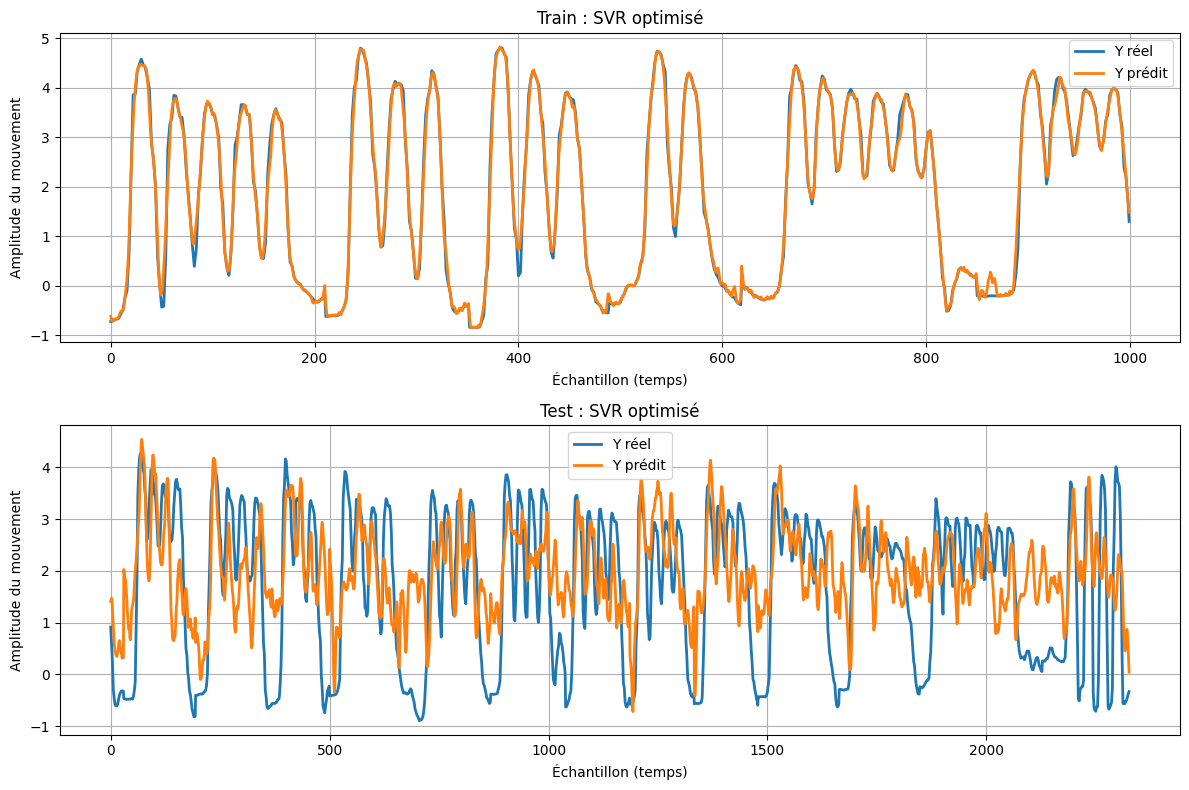

In [ ]:
svr_best = SVR(C=best_params['C'], epsilon=best_params['epsilon'], gamma=best_params['gamma'])
svr_best.fit(Xall_train, Yall_train.ravel())
Y_train_pred = svr_best.predict(Xall_train)
Y_test_pred  = svr_best.predict(Xall_test)

pl.figure(figsize=(12,8))

pl.subplot(2,1,1)
pl.plot(Yall_train, label="Y réel", linewidth=2)
pl.plot(Y_train_pred, label="Y prédit", linewidth=2)
pl.title("Train : SVR optimisé")
pl.xlabel("Échantillon (temps)")
pl.ylabel("Amplitude du mouvement")
pl.legend()
pl.grid(True)

pl.subplot(2,1,2)
pl.plot(Yall_test, label="Y réel", linewidth=2)
pl.plot(Y_test_pred, label="Y prédit", linewidth=2)
pl.title("Test : SVR optimisé")
pl.xlabel("Échantillon (temps)")
pl.ylabel("Amplitude du mouvement")
pl.legend()
pl.grid(True)

pl.tight_layout()
pl.show()



- Ce modèle est meilleur que LS, un peu plus performant que LS avec ridge. Mais Lasso est toujours le meilleur modèle.

3. MPL Classifier : 

In [32]:
mlp = MLPRegressor(max_iter=2000, random_state=42)
mlp.fit(Xall_train, Yall_train.ravel())

Y_train_pred = mlp.predict(Xall_train)
Y_test_pred  = mlp.predict(Xall_test)

MSE_train = mean_squared_error(Yall_train, Y_train_pred)
MSE_test  = mean_squared_error(Yall_test, Y_test_pred)
R2_train  = r2_score(Yall_train, Y_train_pred)
R2_test   = r2_score(Yall_test, Y_test_pred)

print("=== MLP Regressor par défaut ===")
print("MSE train :", MSE_train)
print("MSE test  :", MSE_test)
print("R² train :", R2_train)
print("R² test  :", R2_test)

=== MLP Regressor par défaut ===
MSE train : 0.009230062400608623
MSE test  : 2.5373547961930027
R² train : 0.9970610486041177
R² test  : -0.18986382560034554


- Le MLP overfit énormément sur le training set. Le réseau, avec ses paramètres par défaut, a appris le bruit du training plutôt que la vraie relation signal → mouvement. Le modèle n’est pas capable de généraliser aux nouvelles données.
- Sur le test set, la performance est très mauvaise : le R² négatif indique que le modèle fait pire que de prédire simplement la moyenne.

In [33]:
hidden_layer_sizes_list = [(50,), (100,), (50,50), (100,50)]
activations = ['relu', 'tanh']
learning_rates = ['constant', 'adaptive']

best_test_r2 = -np.inf
best_params = {}

for hl in hidden_layer_sizes_list:
    for act in activations:
        for lr in learning_rates:
            mlp = MLPRegressor(hidden_layer_sizes=hl,
                               activation=act,
                               learning_rate=lr,
                               max_iter=2000,
                               random_state=42)
            mlp.fit(Xall_train, Yall_train.ravel())

            Y_test_pred = mlp.predict(Xall_test)
            r2_test = r2_score(Yall_test, Y_test_pred)

            print(f"HL: {hl}, Activation: {act}, LR: {lr}, R² test: {r2_test:.3f}")

            # Sauvegarder les meilleurs paramètres
            if r2_test > best_test_r2:
                best_test_r2 = r2_test
                best_params = {'hidden_layer_sizes': hl,
                               'activation': act,
                               'learning_rate': lr}

print("\nMeilleurs paramètres :", best_params)
print("R² test correspondant :", best_test_r2)


HL: (50,), Activation: relu, LR: constant, R² test: -0.048
HL: (50,), Activation: relu, LR: adaptive, R² test: -0.048
HL: (50,), Activation: tanh, LR: constant, R² test: -0.138
HL: (50,), Activation: tanh, LR: adaptive, R² test: -0.138
HL: (100,), Activation: relu, LR: constant, R² test: -0.190
HL: (100,), Activation: relu, LR: adaptive, R² test: -0.190
HL: (100,), Activation: tanh, LR: constant, R² test: -0.173
HL: (100,), Activation: tanh, LR: adaptive, R² test: -0.173
HL: (50, 50), Activation: relu, LR: constant, R² test: -0.005
HL: (50, 50), Activation: relu, LR: adaptive, R² test: -0.005
HL: (50, 50), Activation: tanh, LR: constant, R² test: -0.148
HL: (50, 50), Activation: tanh, LR: adaptive, R² test: -0.148
HL: (100, 50), Activation: relu, LR: constant, R² test: 0.013
HL: (100, 50), Activation: relu, LR: adaptive, R² test: 0.013
HL: (100, 50), Activation: tanh, LR: constant, R² test: -0.057
HL: (100, 50), Activation: tanh, LR: adaptive, R² test: -0.057

Meilleurs paramètres : {'

- On voit que les résultats ne changent pas trop, ce modèle fait épreuve d'overfitting.

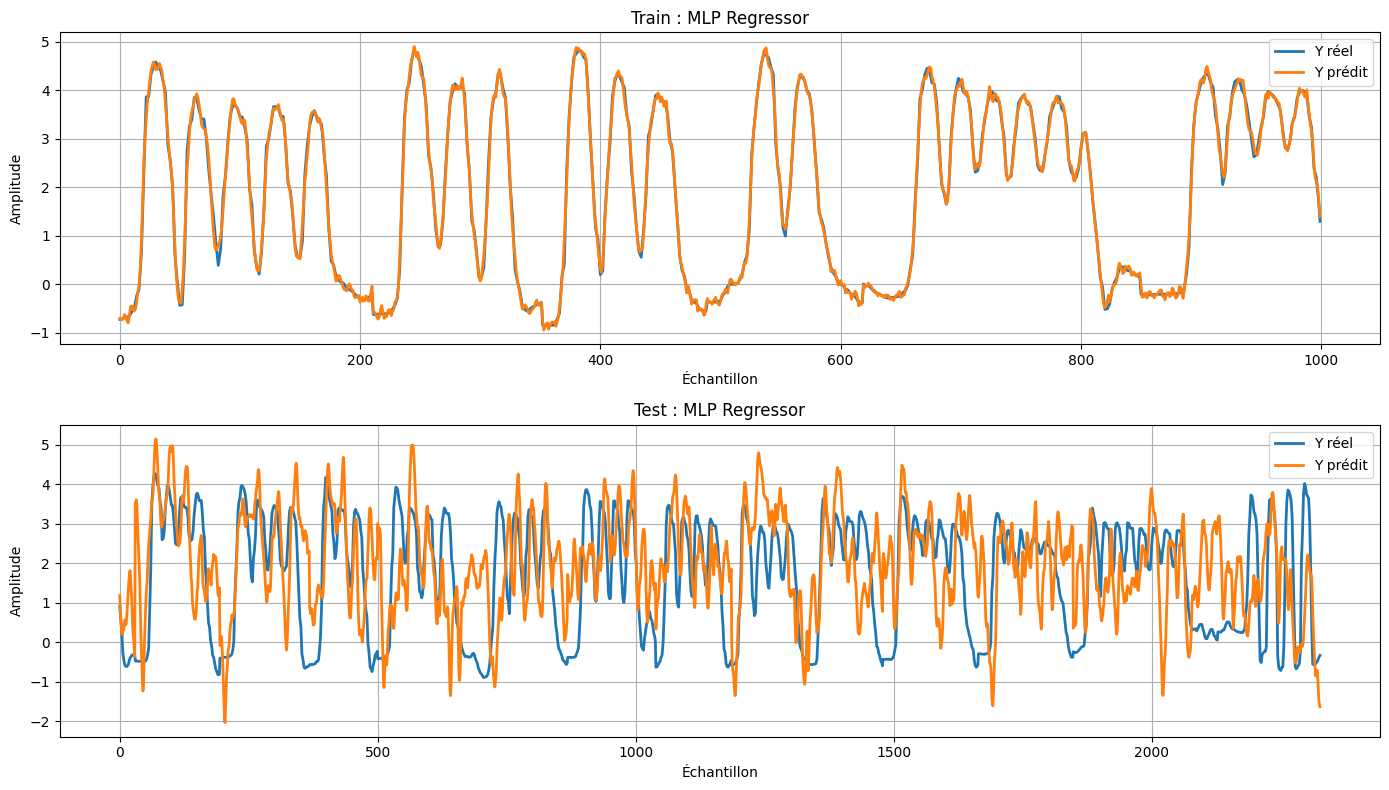

In [ ]:

pl.figure(figsize=(14,8))

pl.subplot(2,1,1)
pl.plot(Yall_train, label="Y réel", linewidth=2)
pl.plot(Y_train_pred, label="Y prédit", linewidth=2)
pl.title("Train : MLP Regressor")
pl.xlabel("Échantillon")
pl.ylabel("Amplitude")
pl.legend()
pl.grid(True)

pl.subplot(2,1,2)
pl.plot(Yall_test, label="Y réel", linewidth=2)
pl.plot(Y_test_pred, label="Y prédit", linewidth=2)
pl.title("Test : MLP Regressor")
pl.xlabel("Échantillon")
pl.ylabel("Amplitude")
pl.legend()
pl.grid(True)

pl.tight_layout()
pl.show()


4. Gradient Boost:


In [35]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(Xall_train, Yall_train.ravel())

Y_train_pred = gbr.predict(Xall_train)
Y_test_pred  = gbr.predict(Xall_test)

MSE_train = mean_squared_error(Yall_train, Y_train_pred)
MSE_test  = mean_squared_error(Yall_test, Y_test_pred)
R2_train  = r2_score(Yall_train, Y_train_pred)
R2_test   = r2_score(Yall_test, Y_test_pred)

print("=== Gradient Boosting Regressor par défaut ===")
print("MSE train :", MSE_train)
print("MSE test  :", MSE_test)
print("R² train :", R2_train)
print("R² test  :", R2_test)


=== Gradient Boosting Regressor par défaut ===
MSE train : 0.11333713838888568
MSE test  : 1.6764294209222497
R² train : 0.9639122330254936
R² test  : 0.21385738915174068


In [36]:
n_estimators_list = [100, 200, 300]
max_depth_list = [2, 3, 4]
learning_rate_list = [0.01, 0.1, 0.2]

best_r2 = -np.inf
best_params = {}

for n_est in n_estimators_list:
    for depth in max_depth_list:
        for lr in learning_rate_list:
            gbr = GradientBoostingRegressor(n_estimators=n_est,
                                          max_depth=depth,
                                          learning_rate=lr,
                                          random_state=42)
            gbr.fit(Xall_train, Yall_train.ravel())
            Y_test_pred = gbr.predict(Xall_test)
            r2_test = r2_score(Yall_test, Y_test_pred)
            
            print(f"n_estimators: {n_est}, max_depth: {depth}, lr: {lr}, R² test: {r2_test:.3f}")
            
            if r2_test > best_r2:
                best_r2 = r2_test
                best_params = {'n_estimators': n_est,
                             'max_depth': depth,
                             'learning_rate': lr}

print("\nMeilleurs paramètres :", best_params)
print("R² test correspondant :", best_r2)

n_estimators: 100, max_depth: 2, lr: 0.01, R² test: 0.142
n_estimators: 100, max_depth: 2, lr: 0.1, R² test: 0.221
n_estimators: 100, max_depth: 2, lr: 0.2, R² test: 0.226
n_estimators: 100, max_depth: 3, lr: 0.01, R² test: 0.139
n_estimators: 100, max_depth: 3, lr: 0.1, R² test: 0.214
n_estimators: 100, max_depth: 3, lr: 0.2, R² test: 0.178
n_estimators: 100, max_depth: 4, lr: 0.01, R² test: 0.152
n_estimators: 100, max_depth: 4, lr: 0.1, R² test: 0.169
n_estimators: 100, max_depth: 4, lr: 0.2, R² test: 0.111
n_estimators: 200, max_depth: 2, lr: 0.01, R² test: 0.185
n_estimators: 200, max_depth: 2, lr: 0.1, R² test: 0.203
n_estimators: 200, max_depth: 2, lr: 0.2, R² test: 0.211
n_estimators: 200, max_depth: 3, lr: 0.01, R² test: 0.185
n_estimators: 200, max_depth: 3, lr: 0.1, R² test: 0.216
n_estimators: 200, max_depth: 3, lr: 0.2, R² test: 0.173
n_estimators: 200, max_depth: 4, lr: 0.01, R² test: 0.183
n_estimators: 200, max_depth: 4, lr: 0.1, R² test: 0.171
n_estimators: 200, max_de

- Cette méthode est bien meilleur que LS simple, mais moins bonne que Ridge et Lasso.

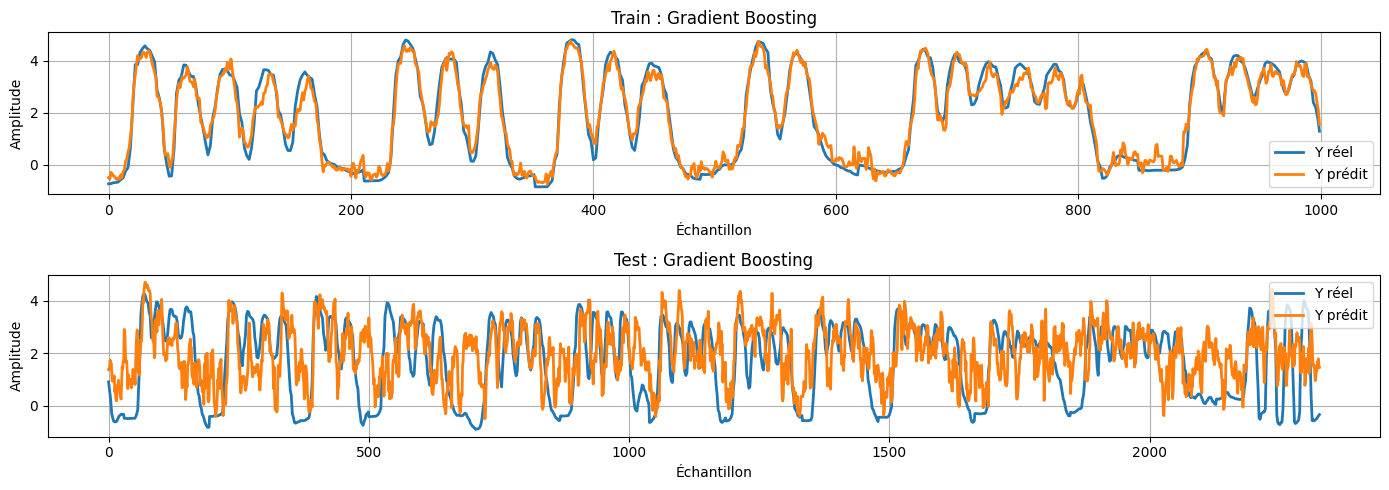

In [37]:
pl.figure(figsize=(14,5))

pl.subplot(2,1,1)
pl.plot(Yall_train, label="Y réel", linewidth=2)
pl.plot(Y_train_pred, label="Y prédit", linewidth=2)
pl.title("Train : Gradient Boosting")
pl.xlabel("Échantillon")
pl.ylabel("Amplitude")
pl.legend()
pl.grid(True)

pl.subplot(2,1,2)
pl.plot(Yall_test, label="Y réel", linewidth=2)
pl.plot(Y_test_pred, label="Y prédit", linewidth=2)
pl.title("Test : Gradient Boosting")
pl.xlabel("Échantillon")
pl.ylabel("Amplitude")
pl.legend()
pl.grid(True)

pl.tight_layout()
pl.show()


## Final Comparison

In [38]:

models = {
    "LS": LinearRegression(),
    "Ridge": Ridge(alpha=1000.0),
    "Lasso": Lasso(alpha=0.12),
    "RandomForest": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "MLP": MLPRegressor(max_iter=2000, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(Xall_train, Yall_train.ravel())
    Y_test_pred = model.predict(Xall_test)
    Y_train_pred = model.predict(Xall_train)
    
    results[name] = {
        "MSE_train": mean_squared_error(Yall_train, Y_train_pred),
        "MSE_test": mean_squared_error(Yall_test, Y_test_pred),
        "R2_train": r2_score(Yall_train, Y_train_pred),
        "R2_test": r2_score(Yall_test, Y_test_pred)
    }

df_results = pd.DataFrame(results).T 
df_results = df_results.sort_values("R2_test", ascending=False)

print(df_results)


                  MSE_train  MSE_test  R2_train   R2_test
Lasso              1.192601  1.367779  0.620263  0.358595
SVR                0.024086  1.515183  0.992331  0.289472
Ridge              1.191284  1.624390  0.620682  0.238261
RandomForest       0.022325  1.625684  0.992892  0.237654
GradientBoosting   0.113337  1.676429  0.963912  0.213857
MLP                0.009230  2.537355  0.997061 -0.189864
LS                 0.504065  3.045537  0.839500 -0.428170


- Best method we found here is **Lasso**.

**Most interpretable models:**

-  LS, Ridge, Lasso, Why: Linear models with clear coefficient interpretation, Each feature has a coefficient showing its direction and magnitude of effect, You can directly see which features matter most and in what direction

**Which is the best from medical practical perspective ?**

- Dans le contexte médical, le choix du modèle ne dépend pas seulement de sa performance, mais aussi de sa robustesse et de son interprétabilité. Les professionnels de santé doivent comprendre quelles variables influencent la prédiction pour pouvoir justifier les décisions.

- Les modèles linéaires comme Ridge ou Lasso sont particulièrement adaptés. Ils offrent des coefficients interprétables qui montrent clairement quelles électrodes ou signaux ECoG influencent le plus la flexion des doigts. Lasso permet aussi de réduire le nombre de variables, simplifiant la mise en place clinique.

- En revanche, les modèles non linéaires comme Random Forest, Gradient Boosting ou MLP sont plus performants mais fonctionnent comme des boîtes noires, difficiles à expliquer. Pour des applications médicales critiques, cette opacité limite la confiance des médecins.


**Do we need non-linearity in this application?**

- Pour ce modèle on voit bien que Lasso et Ridge performent mieux que les autres modèles donc on a pas vraiment besoin de non linéarité pour cet example.

**Is validation on the test data a good practice? What would you do if you need to provide a model to a client for prediction in production ?** 

- Non, valider sur le test set n’est pas une bonne pratique. Le test set doit rester invisible jusqu’à la fin de l’analyse pour donner une estimation fiable de la performance réelle du modèle. Si on utilise le test set pour choisir ou ajuster les hyperparamètres, on risque de sur-ajuster le modèle aux données de test, ce qui conduit à une performance trop optimiste et peu représentative de nouvelles données.

- Pour entraîner un modèle destiné à la production, il est préférable de séparer les données en trois ensembles : training, validation et test. Le training set sert à entraîner le modèle, le validation set à ajuster les hyperparamètres, et le test set uniquement à évaluer la performance finale. Une alternative est d’utiliser la cross-validation sur le training set pour optimiser les paramètres sans toucher au test set.

- En production, le modèle final doit être entraîné sur l’ensemble training + validation avec les meilleurs hyperparamètres trouvés, et le test set reste réservé à l’évaluation finale. Cela garantit que le modèle fourni au client est robuste, généralisable et que les performances annoncées reflètent bien ce que le modèle peut atteindre sur de nouvelles données

## Discussion Personnelle :

- Ce travail a été à la fois stimulant et formatreur. Ce n’était pas simplement une succession d’exercices techniques, mais une véritable exploration du monde de la régression et de la modélisation. J’ai particulièrement apprécié le moment où les graphes et les performances ont enfin “pris sens” — quand j’ai vu comment un simple paramètre λ pouvait transformer un modèle instable en un prédicteur robuste. C’est à ce moment-là que la théorie de la régularisation a cessé d’être abstraite pour devenir tangible.

- Le plus difficile au début a été de jongler entre la compréhension mathématique des méthodes (Ridge, Lasso) et leur implémentation pratique. Le tuning des hyperparamètres m’a aussi surpris : ce n’est pas juste une question de “mettre des valeurs au hasard”, mais un vrai travail d’équilibre entre précision, généralisation et interprétabilité. J’ai compris que les bons résultats ne viennent pas forcément des modèles les plus complexes, mais de ceux qui sont les mieux adaptés à la nature des données.

- Ce que je retiens surtout, c’est la différence entre “un bon modèle sur le papier” et “un bon modèle dans la vraie vie”. Dans un contexte professionnel, et encore plus médical, on ne cherche pas uniquement la performance brute : on veut comprendre pourquoi le modèle prédit ce qu’il prédit. Dans cette optique, j’ai trouvé que Lasso et Ridge incarnaient parfaitement ce compromis entre efficacité et transparence.

- Si je devais recommencer, je mettrais davantage l’accent sur l’interprétation et la visualisation des modèles, car c’est souvent là que la technique devient explicable et utile. Cette séance m’a appris que la data science, ce n’est pas juste du code et des chiffres — c’est avant tout un art d’équilibrer compréhension, rigueur et intuition.